### Example: Analyzing Citibike Station Activity using Pandas

We are going to use the database of snapshots of Citibike stations statuses. 

In [1]:
%matplotlib inline
import pandas as pd
import MySQLdb as mdb
import matplotlib 
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
matplotlib.rcParams['figure.figsize'] = (20,10)

We will first fetch the data from the database.

In [2]:
con = mdb.connect(host = 'localhost', 
                  user = 'root', 
                  passwd = 'dwdstudent2015', 
                  charset='utf8', 
                  use_unicode=True, 
                  database='citibike');

If we try to retrieve all the data, we will see that we have way too many data points (more than 10 million). 

In [3]:
cur = con.cursor(mdb.cursors.DictCursor)
cur.execute("SELECT COUNT(*) AS cnt FROM citibike.Docks_Status")
result = list(cur.fetchall())
cur.close()

result

[{'cnt': 29384297}]

Retrieving millions of data points from the database is going to take long time, and may cause memory errors. 

#### Pushing part of the computation down to the database

The goal of our analysis is to see how bike usage varies over time. Therefore, we can reduce the amount of retrieved data by asking to get back only averages over a period of, say, 60 minutes. 

Unfortunately, SQL does not provide elegant tools for handling time series, do we are going to resort to a few "hacks". We are going to round the `last_communication_time` field in the database into periods of 15 minutes (i.e., 900 seconds), and then compute the average level of "fullness" of the bike station (defined as number of bikes over the number of docks in the station).

* The command `DATE_FORMAT(last_communication_time, '%Y-%m-%d %H:00:00')` truncates each timestamp to the nearest hour.
* We also limit our query to only data from February 13 to March 13th.
* We also limit our query only to statuses where the station was operating and reported back a proper status
* We GROUP BY timestamp and station, and we compute the average fullness level of the station over that time.

 *(Note: The DATE_FORMAT approach works for truncating the timestamp The following, more complicated, code can work for arbitrary time periods. For example, to get 900 intervals (ie 15 mins), we can do `CONCAT(DATE(last_communication_time), ' ',  SEC_TO_TIME((TIME_TO_SEC(last_communication_time) DIV 900) * 900))`)

In [4]:
query = '''
SELECT station_id AS id, 
       AVG(available_bikes/(available_bikes+available_docks)) AS percent_full, 
       DATE_FORMAT(last_communication_time, '%Y-%m-%d %H:00:00') AS communication_time 

FROM citibike.Docks_Status

WHERE  last_communication_time > '2017-02-13' AND last_communication_time < '2017-03-13' 
    AND status_key=1 
    AND available_bikes+available_docks>0
    
GROUP BY station_id, communication_time

'''


In [5]:
cur = con.cursor()
cur.execute(query)
df = pd.DataFrame(list(cur.fetchall()), columns=['id', 'bikes', 'timestamp'])
cur.close()
# We retrieved the data in memory, so we do not need the database connection anymore.
con.close()

In [6]:
len(df)

433343

So, we reduced now our dataset from more than 10+ million data points to around half a million. That will give us a big speedup in our subsequent operations and can easily be handled in-memory by Pandas.

In [7]:
df

,id,bikes,timestamp
0,72,0.33330000,2017-02-13 00:00:00
1,72,0.33330000,2017-02-13 01:00:00
2,72,0.33330000,2017-02-13 02:00:00
3,72,0.33330000,2017-02-13 03:00:00
4,72,0.33330000,2017-02-13 04:00:00
5,72,0.33330000,2017-02-13 05:00:00
6,72,0.31964667,2017-02-13 06:00:00
7,72,0.30468824,2017-02-13 07:00:00
8,72,0.29304286,2017-02-13 08:00:00
9,72,0.40443636,2017-02-13 09:00:00


In [8]:
df.dtypes

id            int64
bikes        object
timestamp    object
dtype: object

Let's convert into proper data types. 

*Note: We use the "astype" as opposed to "pd.to_numeric" for converting the bikes column, because the bikes variable
that comes back from MySQL is a Decimal data type, and Pandas.to_numeric seems to have  problems converting Decimal data types. We can use the technique from http://stackoverflow.com/questions/7483363/python-mysqldb-returns-datetime-date-and-decimal if we want to get back floats instead of Decimals from MySQL.*

*Note2: We use the 'downcast' option to reduce the size of the variables. This reduces memory needs, and can (slightly) improve execution time.*

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['bikes'] = df['bikes'].astype(float)
df['bikes'] = pd.to_numeric(df['bikes'], downcast='float')
df['id'] = pd.to_numeric(df['id'], downcast='unsigned')

df.dtypes

id                   uint16
bikes               float32
timestamp    datetime64[ns]
dtype: object

In [10]:
df.head(10)

,id,bikes,timestamp
0,72,0.333300,2017-02-13 00:00:00
1,72,0.333300,2017-02-13 01:00:00
2,72,0.333300,2017-02-13 02:00:00
3,72,0.333300,2017-02-13 03:00:00
4,72,0.333300,2017-02-13 04:00:00
5,72,0.333300,2017-02-13 05:00:00
6,72,0.319647,2017-02-13 06:00:00
7,72,0.304688,2017-02-13 07:00:00
8,72,0.293043,2017-02-13 08:00:00
9,72,0.404436,2017-02-13 09:00:00


### Exploratory Analysis

As a first step, let's see how the status of the bike stations evolves over time. We compute the average "fullness" of all the bike stations over time. We can use the `groupby` function of pandas, and compute the `mean()` for the groups.

In [11]:
# Notice that this also returns an average for the station ID's which is kind of useless
# We will eliminate these next.
df.groupby('timestamp').mean()

,id,bikes
timestamp,,
2017-02-13 00:00:00,1901.245614,0.368884
2017-02-13 01:00:00,1898.854633,0.369463
2017-02-13 02:00:00,1901.054400,0.368175
2017-02-13 03:00:00,1901.054400,0.368799
2017-02-13 04:00:00,1901.054400,0.370133
2017-02-13 05:00:00,1901.054400,0.368350
2017-02-13 06:00:00,1903.177316,0.365719
2017-02-13 07:00:00,1903.533546,0.358422
2017-02-13 08:00:00,1912.195860,0.342012


In [12]:
df.groupby('timestamp').mean()['bikes']

timestamp
2017-02-13 00:00:00    0.368884
2017-02-13 01:00:00    0.369463
2017-02-13 02:00:00    0.368175
2017-02-13 03:00:00    0.368799
2017-02-13 04:00:00    0.370133
2017-02-13 05:00:00    0.368350
2017-02-13 06:00:00    0.365719
2017-02-13 07:00:00    0.358422
2017-02-13 08:00:00    0.342012
2017-02-13 09:00:00    0.342488
2017-02-13 10:00:00    0.349422
2017-02-13 11:00:00    0.351237
2017-02-13 12:00:00    0.348421
2017-02-13 13:00:00    0.349198
2017-02-13 14:00:00    0.350876
2017-02-13 15:00:00    0.348750
2017-02-13 16:00:00    0.346147
2017-02-13 17:00:00    0.340667
2017-02-13 18:00:00    0.347604
2017-02-13 19:00:00    0.360420
2017-02-13 20:00:00    0.366226
2017-02-13 21:00:00    0.369280
2017-02-13 22:00:00    0.371487
2017-02-13 23:00:00    0.373140
2017-02-14 00:00:00    0.374234
2017-02-14 01:00:00    0.375715
2017-02-14 02:00:00    0.376464
2017-02-14 03:00:00    0.377606
2017-02-14 04:00:00    0.378852
2017-02-14 05:00:00    0.377503
                         ...  

Now let's plot the activity over time. We can see that the percentage of bikes in the stations falls from 35% overnight to 30% during the morning and evening commute times, while the average availability during the day is around 31%.

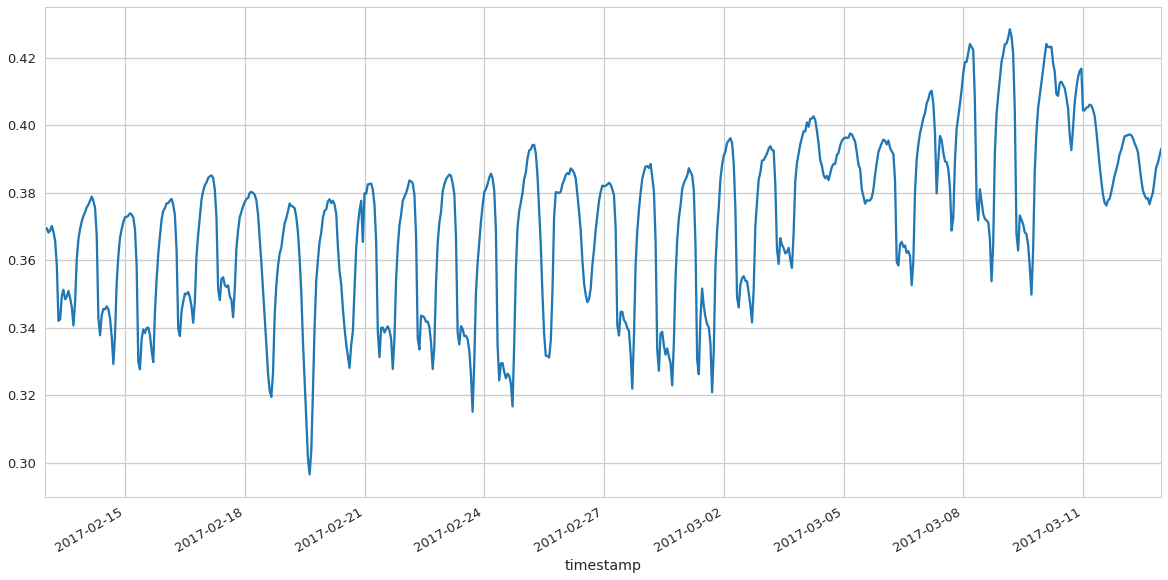

In [13]:
df.groupby('timestamp').mean()['bikes'].plot(
    figsize=(20,10), grid=True
)

Let's do also the seasonal decomposition to see the result.

In [55]:
!sudo pip3 install statsmodels

The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.


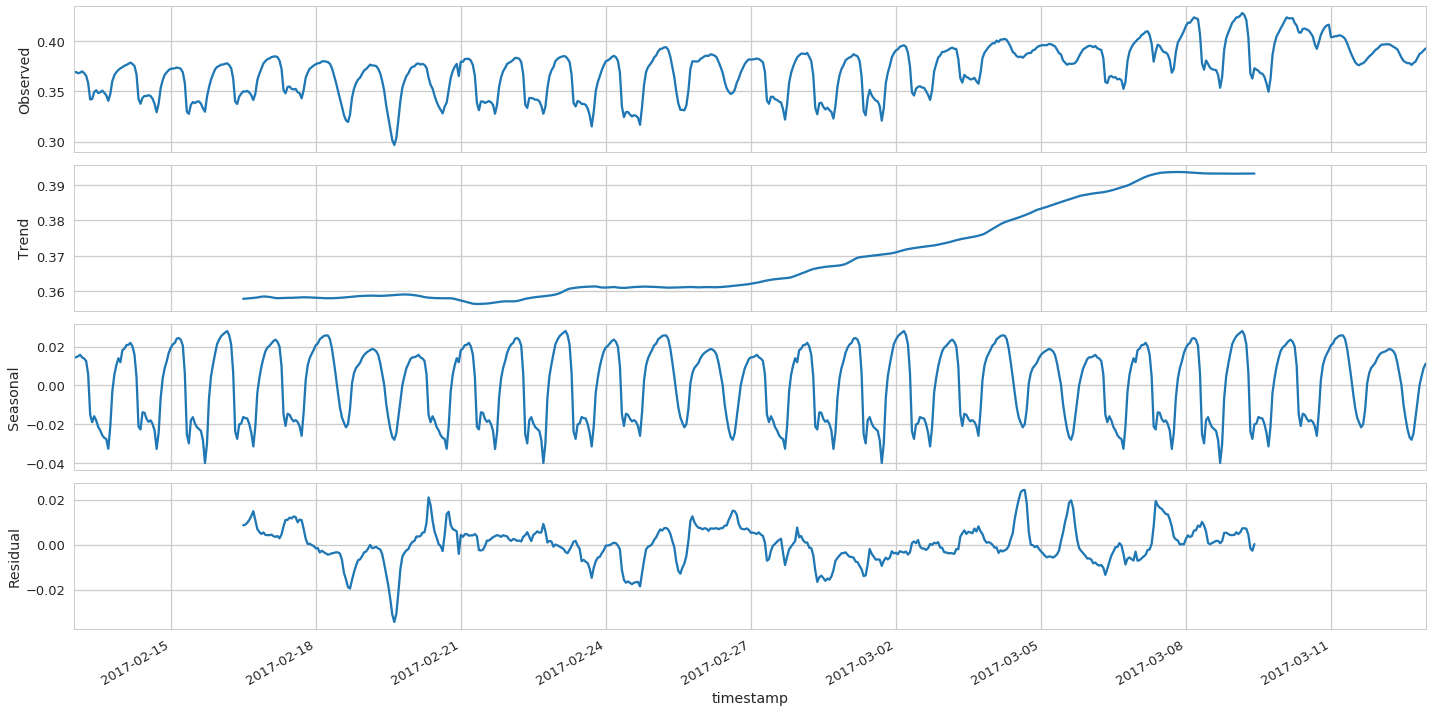

In [54]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

time_series = df.groupby('timestamp').mean()['bikes']

# We decompose assumming a 24-hour periodicity. There is a weekly component as well, which we ignore
decomposition = seasonal_decompose(time_series, freq=168)

seasonal = decomposition.plot()  

### Examining Time Series per Station

We now create a pivot table, to examine the time series for individual stations.

Notice that we use the `fillna` method, where we fill the cells where we do not have values using the prior, non-missing value.

In [56]:
import numpy as np
df2 = df.pivot_table(
    index='timestamp', 
    columns='id', 
    values='bikes', 
    aggfunc=np.mean
).interpolate(method='time') 
df2

id,72,79,82,83,116,119,120,127,128,143,...,3438,3440,3443,3445,3447,3449,3452,3453,3454,3455
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-02-13 00:00:00,0.333300,0.010694,0.440000,0.450000,0.219556,0.736800,0.444400,1.000000,0.137900,0.166700,...,0.460174,0.023300,0.000000,0.333300,0.122000,NaN,NaN,NaN,NaN,NaN
2017-02-13 01:00:00,0.333300,0.030300,0.440000,0.450000,0.230800,0.736800,0.444400,0.981269,0.112600,0.166700,...,0.466700,0.023300,0.000000,0.333300,0.122000,NaN,NaN,NaN,NaN,NaN
2017-02-13 02:00:00,0.333300,0.030300,0.440000,0.450000,0.230800,0.736800,0.444400,0.966700,0.103400,0.166700,...,0.465693,0.023300,0.000000,0.333300,0.122000,NaN,NaN,NaN,NaN,NaN
2017-02-13 03:00:00,0.333300,0.030300,0.440000,0.450000,0.230800,0.736800,0.444400,0.966700,0.103400,0.166700,...,0.451600,0.023300,0.000000,0.333300,0.122000,NaN,NaN,NaN,NaN,NaN
2017-02-13 04:00:00,0.333300,0.030300,0.440000,0.450000,0.230800,0.736800,0.444400,0.966700,0.073587,0.166700,...,0.451600,0.023300,0.000000,0.333300,0.122000,NaN,NaN,NaN,NaN,NaN
2017-02-13 05:00:00,0.333300,0.030300,0.440000,0.453131,0.263287,0.736800,0.444400,0.966700,0.042618,0.169141,...,0.437512,0.024847,0.000000,0.333300,0.122000,NaN,NaN,NaN,NaN,NaN
2017-02-13 06:00:00,0.319647,0.024619,0.440000,0.467807,0.291135,0.736800,0.441135,0.958841,0.020294,0.230148,...,0.392800,0.046500,0.025925,0.333300,0.122000,NaN,NaN,NaN,NaN,NaN
2017-02-13 07:00:00,0.304688,0.007129,0.475294,0.497553,0.264983,0.736800,0.350675,0.859244,0.012938,0.354183,...,0.383063,0.046500,0.281508,0.347007,0.137724,NaN,NaN,NaN,NaN,NaN
2017-02-13 08:00:00,0.293043,0.008912,0.475294,0.515894,0.289379,0.798765,0.263000,0.662956,0.236450,0.560768,...,0.293894,0.121759,0.633087,0.329083,0.110518,NaN,NaN,NaN,NaN,NaN


Let's plot the time series for *all* bike stations, for a couple of days in February.

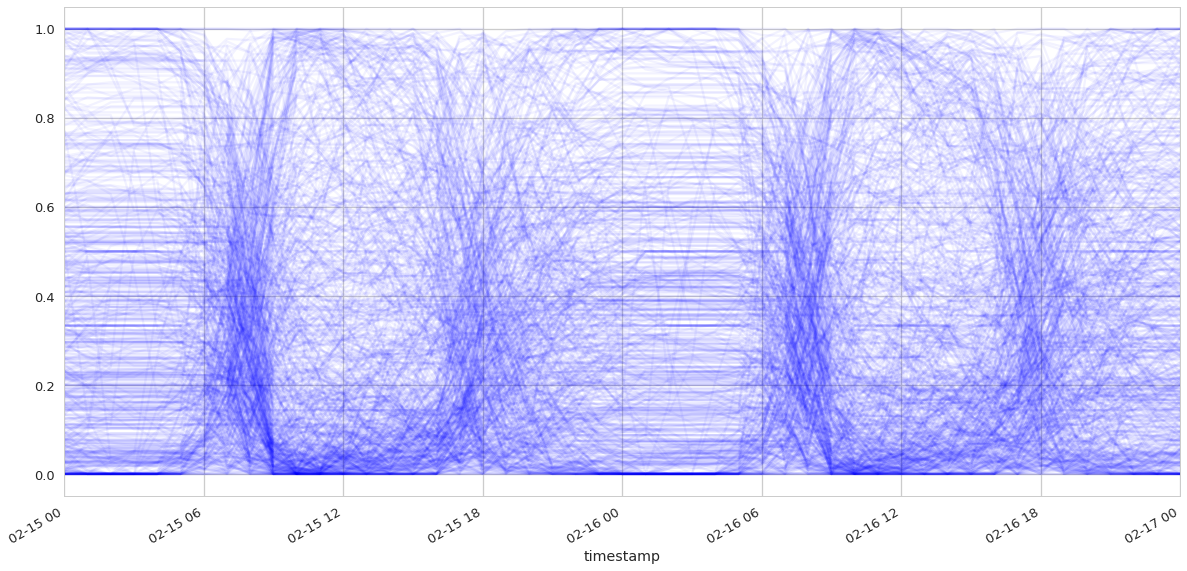

In [58]:
df2.plot(
    alpha=0.05, 
    color='b', 
    legend=False, 
    figsize=(20,10), 
    xlim=('2017-02-15','2017-02-17')
)

Let's limit our plot to just two stations:
* Station 3260 at "Mercer St & Bleecker St"
* Station 161 at "LaGuardia Pl & W 3 St"

which are nearby and tend to exhibit similar behavior. Remember that the list of stations is [available as a JSON](https://feeds.citibikenyc.com/stations/stations.json) 

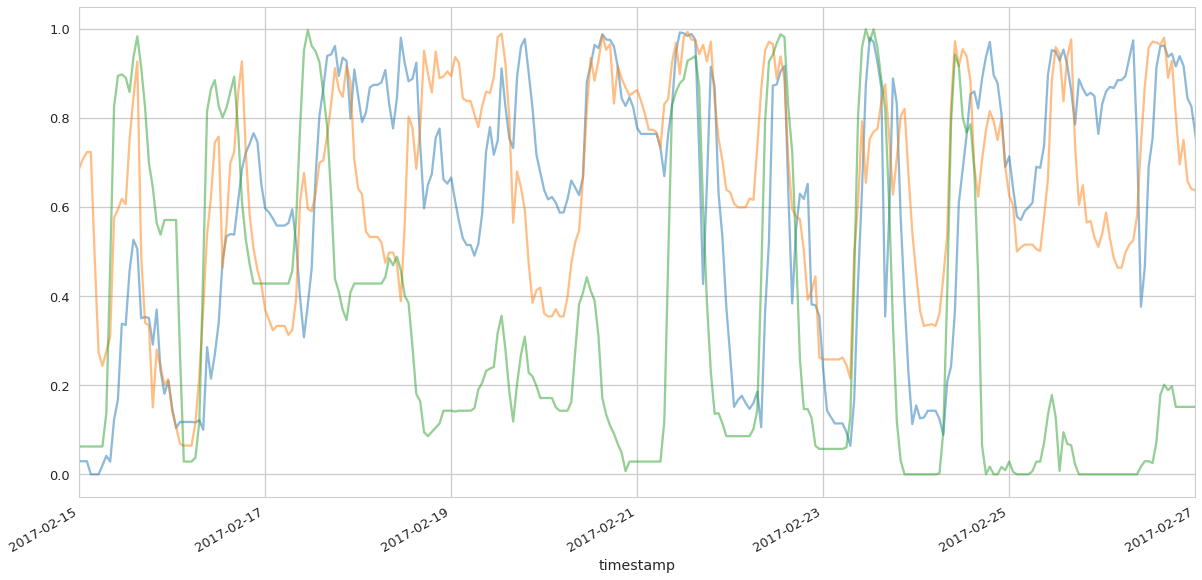

In [62]:
df2[[161, 3260, 260]].plot(
    alpha=0.5,  
    legend=False, 
    figsize=(20,10), 
   xlim=('2017-02-15','2017-02-27')
)

### Finding Bike Stations with Similar Behavior

For our next analysis, we are going to try to find bike stations that have similar behaviors over time. A very simple technique that we can use to find similar time series is to treat the time series as vectors, and compute their correlation. Pandas provides the `corr` function that can be used to calculate the correlation of columns. (If we want to compute the correlation of rows, we can just take the transpose of the dataframe using the `transpose()` function, and compute the correlations there.)

In [22]:
similarities = df2.corr(method='pearson')
similarities

id,72,79,82,83,116,119,120,127,128,143,...,3438,3440,3443,3445,3447,3449,3452,3453,3454,3455
id,,,,,,,,,,,,,,,,,,,,,
72,1.000000,-0.009734,0.012223,0.005283,0.142925,0.039245,0.054251,0.129108,0.199034,0.052493,...,-0.059576,-0.108445,0.040515,0.128389,-0.021751,0.220907,0.150157,0.385665,-0.165113,-0.368392
79,-0.009734,1.000000,-0.246768,0.536225,-0.193042,0.307865,0.017583,-0.226910,0.293365,0.305424,...,-0.010784,0.182329,0.164144,-0.432533,-0.127786,-0.051423,0.098883,0.183053,-0.498407,-0.610691
82,0.012223,-0.246768,1.000000,-0.265721,-0.104862,-0.165140,-0.070519,0.151874,-0.064410,-0.246282,...,0.013997,0.125320,0.071001,-0.049795,0.356456,0.257512,-0.099725,0.031188,-0.249353,-0.327830
83,0.005283,0.536225,-0.265721,1.000000,-0.083330,0.232784,0.169186,-0.007499,0.185422,0.111380,...,-0.131187,0.002872,0.107407,-0.182906,-0.314356,0.063275,0.368954,0.179193,-0.217989,-0.594336
116,0.142925,-0.193042,-0.104862,-0.083330,1.000000,-0.442488,-0.141933,-0.085298,0.329862,0.150556,...,-0.434530,0.141331,0.184780,-0.137808,-0.088354,-0.292073,-0.279795,-0.171223,-0.447509,0.069352
119,0.039245,0.307865,-0.165140,0.232784,-0.442488,1.000000,0.169042,0.069076,-0.144357,0.001480,...,0.545306,-0.257898,-0.199233,0.085460,0.028212,0.041424,0.358347,0.339454,0.354544,0.085313
120,0.054251,0.017583,-0.070519,0.169186,-0.141933,0.169042,1.000000,0.120811,-0.205121,-0.324903,...,0.130718,-0.510063,-0.442057,0.197755,-0.042016,0.515148,0.457940,0.096194,-0.171153,-0.454958
127,0.129108,-0.226910,0.151874,-0.007499,-0.085298,0.069076,0.120811,1.000000,-0.357878,-0.235311,...,0.093995,-0.337788,-0.206758,0.234766,0.055879,-0.106974,0.171176,-0.129788,0.527901,0.136124
128,0.199034,0.293365,-0.064410,0.185422,0.329862,-0.144357,-0.205121,-0.357878,1.000000,0.472066,...,-0.383912,0.389052,0.352936,-0.250072,0.143272,0.031351,-0.143700,0.316442,-0.429077,-0.470342


Let's see the similarities of the two stations that we examined above.

In [64]:
stations = [161, 3260]

similarities[stations].loc[stations]

id,161,3260,336
id,,,
161,1.000000,0.520664,0.465577
3260,0.520664,1.000000,0.397028
336,0.465577,0.397028,1.000000


For bookkeeping purposes, we are going to drop columns that contain NaN values, as we cannot use such similarity values.

In [65]:
similarities.dropna(axis=0, how='any', inplace=True)

We are now going to convert our similarities into distance metrics, that are positive, and bounded to be between 0 and 1.

* If two stations have correlation 1, they behave identically, and therefore have distance 0, 
* If two stations have correlation -1, they have exactly the oppositite behaviors, and therefore we want to have distance 1 (the max) 

In [66]:
distances = ((.5*(1-similarities))**2)
distances

id,72,79,82,83,116,119,120,127,128,143,...,3438,3440,3443,3445,3447,3449,3452,3453,3454,3455
id,,,,,,,,,,,,,,,,,,,,,
72,0.000000,0.254891,0.243926,0.247365,0.183644,0.230762,0.223610,0.189613,0.160387,0.224442,...,0.280675,0.307163,0.230153,0.189926,0.260994,0.151746,0.180558,0.094352,0.339372,0.468124
79,0.254891,0.000000,0.388608,0.053772,0.355838,0.119763,0.241286,0.376327,0.124833,0.120609,...,0.255421,0.167147,0.174664,0.513038,0.317975,0.276372,0.203003,0.166851,0.561306,0.648582
82,0.243926,0.388608,0.000000,0.400512,0.305180,0.339388,0.286503,0.179829,0.283242,0.388305,...,0.243051,0.191266,0.215760,0.275517,0.103537,0.137822,0.302349,0.234649,0.390221,0.440783
83,0.247365,0.053772,0.400512,0.000000,0.293401,0.147155,0.172563,0.253764,0.165884,0.197412,...,0.319896,0.248566,0.199181,0.349817,0.431883,0.219363,0.099555,0.168431,0.370875,0.635477
116,0.183644,0.355838,0.305180,0.293401,0.000000,0.520193,0.326003,0.294468,0.112271,0.180389,...,0.514469,0.184328,0.166146,0.323652,0.296129,0.417363,0.409469,0.342941,0.523821,0.216526
119,0.230762,0.119763,0.339388,0.147155,0.520193,0.000000,0.172623,0.216655,0.327388,0.249260,...,0.051687,0.395577,0.359540,0.209096,0.236093,0.229717,0.102930,0.109080,0.104153,0.209163
120,0.223610,0.241286,0.286503,0.172563,0.326003,0.172623,0.000000,0.193243,0.363079,0.438842,...,0.188913,0.570073,0.519882,0.160899,0.271449,0.058770,0.073457,0.204216,0.342900,0.529226
127,0.189613,0.376327,0.179829,0.253764,0.294468,0.216655,0.193243,0.000000,0.460958,0.381498,...,0.205211,0.447419,0.364066,0.146396,0.222841,0.306348,0.171737,0.319105,0.055719,0.186571
128,0.160387,0.124833,0.283242,0.165884,0.112271,0.327388,0.363079,0.460958,0.000000,0.069679,...,0.478803,0.093314,0.104673,0.390670,0.183496,0.234570,0.327012,0.116813,0.510565,0.540477


### Clustering Based on Distances

Without explaining too much about clustering, we are going to use a clustering technique and cluster together bike stations that are "nearby" according to our similarity analysis. The code is very simple:

In [68]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=2)
cluster.fit(distances.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

We will now take the results of the clustering and associate each of the data points into a cluster.

In [69]:
labels = pd.DataFrame(list(zip(distances.index.values.tolist(), cluster.labels_)), columns = ["id", "cluster"])
labels.head(10)

,id,cluster
0,72,1
1,79,1
2,82,0
3,83,1
4,116,1
5,119,0
6,120,0
7,127,0
8,128,1
9,143,1


Let's see how many stations in each cluster

In [70]:
labels.groupby('cluster').count()

,id
cluster,
0,395
1,248


### Visualizing the Time Series Clusters

We will start by assining a color to each cluster, so that we can plot each station-timeline with the cluster color. (We put a long list of colors, so that we can play with the number of clusters in the earlier code, and still get nicely colored results.)

In [71]:
colors = list(['r','b', 'g', 'm', 'y', 'k', 'w', 'c'])
labels['color'] = labels['cluster'].apply(lambda cluster_id : colors[cluster_id]) 
labels.head(10)

,id,cluster,color
0,72,1,b
1,79,1,b
2,82,0,r
3,83,1,b
4,116,1,b
5,119,0,r
6,120,0,r
7,127,0,r
8,128,1,b
9,143,1,b


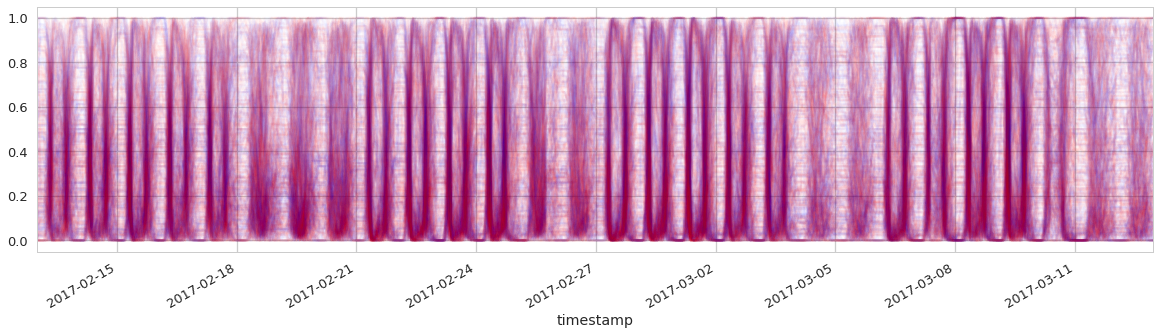

In [75]:
stations_plot = df2.plot(
    alpha=0.02, 
    legend=False, 
    figsize=(20,5), 
    color=labels["color"],
    #xlim=('2017-02-15','2017-02-17')
)

The plot still looks messy. Let's try to plot instead a single line for each cluster. To represent the cluster, we are going to use the _median_ fullness value across all stations that belong to a cluster, for each timestamp. For that, we can again use a pivot table: we define the `timestamp` as one dimension of the table, and `cluster` as the other dimension, and we use the `percentile` function to compute the median. 

For that, we first _join_ our original dataframe with the results of the clustering, using the `merge` command, and add an extra column that includes the clusterid for each station. Then we compute the pivot table.

In [80]:
import numpy as np

median_cluster = df.merge(
    labels, 
    how='inner', 
    on='id'
).pivot_table(
    index='timestamp', 
    columns='cluster', 
    values='bikes', 
    aggfunc=lambda x: np.percentile(x, 50) # median
)

median_cluster

cluster,0,1
timestamp,,
2017-02-13 00:00:00,0.395300,0.190500
2017-02-13 01:00:00,0.407400,0.190500
2017-02-13 02:00:00,0.407400,0.185600
2017-02-13 03:00:00,0.407400,0.188250
2017-02-13 04:00:00,0.407400,0.188250
2017-02-13 05:00:00,0.407400,0.190356
2017-02-13 06:00:00,0.395300,0.218844
2017-02-13 07:00:00,0.357813,0.256659
2017-02-13 08:00:00,0.296300,0.293100


Now, we can plot the medians for the two clusters.

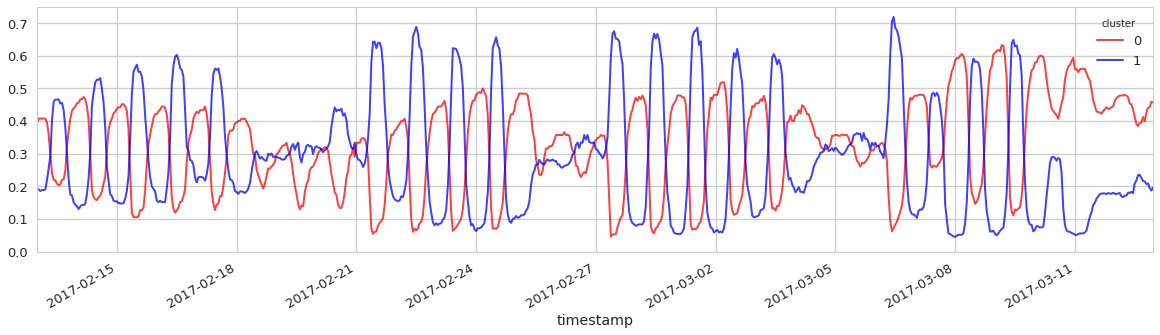

In [82]:
median_plot = median_cluster.plot(
        figsize=(20,5), 
        linewidth = 2, 
        alpha = 0.75,
        color=colors,
        ylim = (0,0.75),
        grid = True
    )

And just for fun and for visual decoration, let's put the two plots together. We are going to fade a lot the individual station time series (by putting the `alpha=0.01`) and we are going to make more prominent the median lines by increasing their linewidths. We will limit our plot to one week's worth of data:

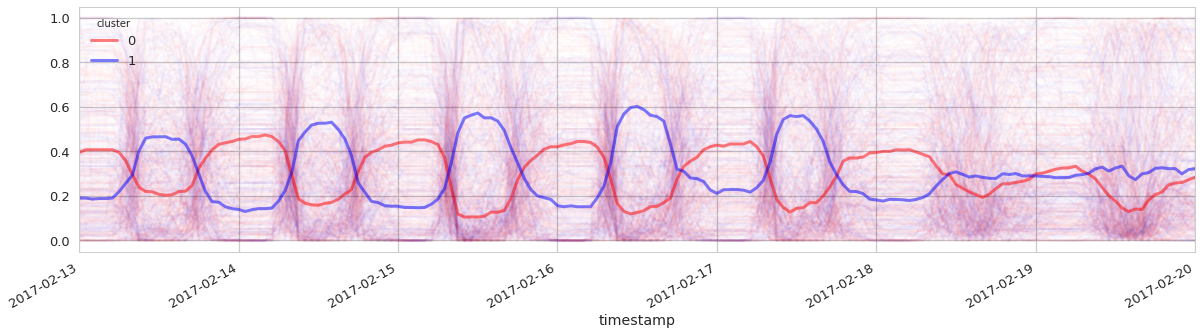

In [83]:
stations_plot = df2.plot(
    alpha=0.01, 
    legend=False, 
    figsize=(20,5), 
    color=labels["color"]
)

median_cluster.plot(
    figsize=(20,5), 
    linewidth = 3, 
    alpha = 0.5,
    color=colors, 
    xlim=('2017-02-13','2017-02-20'),
    ax = stations_plot
)